# Konvertering fra korpus i pdf til et vasket korpus i ren tekst

## Etablering av et pdf-korpus

Nettstedet [reiselivsforum.no](reiselivsforum.no) publiserer avgjørelser fra Transportklagenemnda og Pakkereisenemnda.  Vi har lastet ned alle avgjørelsen i pdf-format. Nettsiden tilbyr ikke samlet nedlasting av alle avgjørelser; det er nødvendig å lage et eget program for å laste ned alle. Vi har utviklet et skript i Python-modulen Scrapy som har lastet ned filer. Alle pdf-er er lastet ned til samme mappe. Pdf-ene er lagret med saksnummeret som filnavn. Søkemotoren på reiselivsforum.no oppgir totalt antall vedtak til 12853 pr. 15. oktober 2023. Skriptet lastet ned 12595 vedtak. Hva diskrepansen på 258 vedtak skyldes, vet vi ikke. 



**XXXXXXXXX            SLETTER FRA HER**

Mange av de eldre vedtakene har et rettighetsforbehold fra Lovdata. Forbeholdet ser ut til å være  standardformulering, og den er lik  i alle vedtakene med forbehold:
> De publiserte nemndsavgjørelsene er bearbeidet av stiftelsen Lovdata, som innehar rettighetene til dokumentene. Utnyttelse av nemndsavgjørelsene til forlagsvirksomhet, distribusjon, drift av søkbare databaser eller opplæringsvirksomhet krever særskilt avtale med Lovdata. Lovdata avgjør i tvilstilfelle hva som faller inn under nevnte kategorier.>


Her kan det være verdt å merke seg at forbeholdet står i vedtakene som er tilgjengelig for nedlasting på nemndenes egen nettside. 

For å ikke komme i konflikt med rettighetsreservasjonen, fjerner vi de aktuelle vedtakene fra tekstkorpuset. Tilsammen fjerner vi da 4768 vedtak. De fordeler seg som følger.**

| Nemnd                   | Vedtak med rettighetsforbehold |
|:------------------------| ------------------------------:|
|Pakkereiseklagenemnda    | 1734                           |
|Transportklagenemnda-Tog | 171                            |
|Transportklagenmnda-Fly  | 2863                           |
|**Sum:**                 |**4768**                        |

Vi står da igjen med 7827 vedtak fra 2017 til 2023. Søk i de gjenværende vedtakene bekrefter at de ikke har den samme rettighetsreservasjonen.

**XXXXXXXXXXXX          TIL HIT**


**Her må vi inn med en oversikt over antall vedtak pr. år. pr. nemnd. Kanskje det blir mulig å si noe om de 258 vi manglet også.**


## Konverting av pdf-er til ren tekst

For at avgjørelsene skal kunne brukes videre og behandles maskinelt, må pdf-ene konverteres til ren tekst. Nøyaktig konvertering til ren tekst er viktig for å kunne identifisere de ulike delene av vedtaket. Særlig kommer dette godt med når vi skal identifisere mindretallsvotum, og når vi skal eksperimentere med å bruke ulike deler av dokumentet som kontekst for språkmodellen (se under).

Vi prøver først å konvertere et vedtak i pdf til tekst med PyPDF2. 

In [1]:
import os
import PyPDF2

def pdf_to_text_pyPDF2(pdf_path):
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)        
        text = ""
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()    
    return text

path_to_pdf = "./transportklagenemnda_pdfs/2016-00003.pdf"
text = pdf_to_text_pyPDF2(path_to_pdf)
print(text)

Vedtak i Pakkereisenemnda
Sammendrag
Krav om dekning av merutgifter da togreisen "Norway in a nutshell" ble kansellert.
Dato
30.04.2017
Saksnummer
2016-00003
Tjenesteytere
Fjord Tours
Klager har i det vesentlige anført
Klager bestilte reisen "Norway in a nutshell" fra Oslo 15. - 16. oktober 2016 hos Fjord
Tours.
Først da klager ankom Myrdal, fant de ut at togreisen "Norway in a nutshell" var
kansellert. Klager ble ikke informert om dette.  
Hverken Fjord Tours eller NSB vil dekke klagers merutgifter til hotell, ﬂy, buss, taxi, tog og
tapt arbeidsfortjeneste.
Klager har fått refundert prisen for "Norway in a nutshell" med kr. 5.300, men krever å
få dekket de øvrige merutgiftene på kr. 6.270,57 fra Fjord Tours i og med at han bestilte
reisen hos Fjord Tours og ikke direkte hos NSB.
Det vises for øvrig til korrespondanse fra klager.
Tjenesteyterne har i det vesentlige anført
Fjord Tours har anført at saken er avsluttet fra Fjord Tours side da de i mail av 18.10.2016
informerte om at de vi

Som vi ser mangler det en del struktur. Det er vanskelig å identifisere overskrifter og avsnitt. Vi prøver derfor å konvertere pdf-ene til ren tekst med **tika**. Tika returner tekst med bedre struktur, men den kan forbedres litt:
- Vi får en del blanke linjer i begynnelsen og slutten av vedtakene. Dette kan vi fjerne med strip-funksjonen.
- Vi får noen ekstra linjeskift der pdf-ene har sideskift. 

Innspeksjon av flere vedtak viser at sideskift i pdf-en konverteres til fire linjeskift, dvs. `("\n\n\n\n")`. Hvis vi fjerner alle fire vil vi få sammenhengende tekst, men i noen tilfeller skal det være linjeskift på samme sted som sideskiftet. Innspeksjon av konverterte tekstfiler viser at det ofte er et mellomrom foran de fire linjeskiftene der det skal være et linjeskift, men dette gjelder ikke alltid. Vi velger derfor å fjerne to linjeskift som et utgangspunkt. Da unngår vi å fjerne linjeskift der det skal være et. I tilfeller der linjen etter sideskiftet begynner med liten bokstav antar vi at det bare skal være et ordinært linjeskift. Da fjerner vi tre linjeskift. Denne tilnærmingen løser mye, men har en svakhet: Vi skiller ikke mellom sideskift som kommer der det er nytt avsnitt i teksten og sideskift der det kommer en ny setning i teksten. Konsekvensen er at sideskift som faller sammen med at ny setning i samme avsnitt påbegynnes, innfører en ekstra avsnittsmarkering. For vårt formål virker dette å være uproblematisk.

In [12]:
import os
import tika
from tika import parser
import re

os.environ['TIKA_SERVER_ENDPOINT'] = 'http://localhost:9998'

print("TIKA_SERVER_JAR =", os.environ.get('TIKA_SERVER_JAR'))

parsed_pdf = parser.from_file("./transportklagenemnda_pdfs/2016-00003.pdf")
vedtak_txt = parsed_pdf['content'].strip()

# Bruker et regulært uttrykk for å identifisere sideskift etterfulgt av liten forbokstav
pattern = r'\n\n\n\n(?=[a-z])'
vedtak_txt = re.sub(pattern, '\n', vedtak_txt)

# Resten av sideskiftene bytter vi ut med to linjeskift
vedtak_txt = vedtak_txt.replace('\n\n\n\n', '\n\n')
# print(repr(vedtak_txt)) # repr() viser linjeskift i teksten
print(vedtak_txt)


TIKA_SERVER_JAR = /Users/hanscfa/Git/Transportklagenmenda/tika-server-standard-2.6.0.jar
Vedtak i Pakkereisenemnda

Sammendrag

Krav om dekning av merutgifter da togreisen "Norway in a nutshell" ble kansellert.

Dato
30.04.2017

Saksnummer
2016-00003

Tjenesteytere
Fjord Tours

Klager har i det vesentlige anført

Klager bestilte reisen "Norway in a nutshell" fra Oslo 15. - 16. oktober 2016 hos Fjord
Tours.

Først da klager ankom Myrdal, fant de ut at togreisen "Norway in a nutshell" var
kansellert. Klager ble ikke informert om dette.  

Hverken Fjord Tours eller NSB vil dekke klagers merutgifter til hotell, fly, buss, taxi, tog og
tapt arbeidsfortjeneste.

Klager har fått refundert prisen for "Norway in a nutshell" med kr. 5.300, men krever å
få dekket de øvrige merutgiftene på kr. 6.270,57 fra Fjord Tours i og med at han bestilte
reisen hos Fjord Tours og ikke direkte hos NSB.

Det vises for øvrig til korrespondanse fra klager.

Tjenesteyterne har i det vesentlige anført
Fjord Tours h

Resultatet er bedre. Mye struktur er bevart, og vi har fjernet en rekke unødvendige linjeskift.

*Arbeidet med å få orden på teksten med linjeskift og avsnitt burde i og for seg ha vært unødvendig. I Lovdata ligger teksten ferdig kodet med riktig struktur, men den er altså ikke allment tilgjengelig.* 

## Konvertere alle vedtak til tekst

Etter denne innledende utprøvingen, konverterer utvider vi koden slik at vi konverterer alle vedtak til ren tekst.
(Vi skal gjøre en operasjon til på vedtakene, men skiller denne ut til et eget etterfølgende steg)

In [15]:
from tika import parser
import os
import re

pdf_directory = './transportklagenemnda_pdfs/'
txt_directory = './transportklagenmnda_txt/'

for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, filename)
        parsed_pdf = parser.from_file(pdf_path)
        vedtak_txt = parsed_pdf['content'].strip()

        # Bruker et regulært uttrykk for å identifisere sideskift etterfulgt av liten forbokstav
        pattern = r'\n\n\n\n(?=[a-z])'
        vedtak_txt = re.sub(pattern, '\n', vedtak_txt)

        # Resten av sideskiftene bytter vi ut med to linjeskift
        vedtak_txt = vedtak_txt.replace('\n\n\n\n', '\n\n')
        
        # Lagrer vedtak som ren tekst.
        
        # Setter sammen nytt navn til filene
        txt_filename = os.path.splitext(filename)[0] + '.txt'  
        txt_path = os.path.join(txt_directory, txt_filename)
        
        # Sjekker om folderen for lagring finnes, hvis ikke oppretter vi en
        if not os.path.exists(txt_directory):
            os.makedirs(txt_directory)

        # Lagrer filen
        with open(txt_path, 'w', encoding='utf-8') as txt_file:
            txt_file.write(vedtak_txt) 
        

Resultatet er 12595 vedtak konvert til ren tekst og lagret som individuelle filer med endelsen '.txt'.

## Fjerne nemndas representanter fra vedtaksteksten

Alle vedtak ender med en liste over nemndas representanter. Til vårt formål er det ikke nødvendig å ha med denne informasjonen videre. Vi skal derfor slette denne informasjonen før vi tar i bruk vedtakene.

For å være sikre på at vi bare sletter nemndas representanter, kjører vi en test. Vi identifiserer da overskriften "Nemndas representanter" og sjekker hvor mange linjer tekstt denne delen består av. 

Først sjekker vi om alle vedtakene har en slik overskrift.

In [17]:
import os

txt_directory = './transportklagenmnda_txt/'
search_string = "Nemndas representanter\n"
teller = 0 # variabel for å telle hvor mange filer vi har sjekket

# Looper over alle filer i folderen
for filename in os.listdir(txt_directory):
    if filename.endswith('.txt'):  
        txt_path = os.path.join(txt_directory, filename)  
        
        # Leser inn filen
        with open(txt_path, 'r', encoding='utf-8') as txt_file:  
            file_content = txt_file.read()  
            teller += 1
            # Sjekker om det søkestrengen ikke er i filen
            if search_string not in file_content:
                print(f'"{filename}" inneholder ikke teksten "{search_string.strip()}"')
       #    Kode for å sjekke at filene faktisk inneholder strengen.
       #     if search_string  in file_content:
       #         print(f'"{filename}" inneholder teksten "{search_string.strip()}"')
                

print(teller)


12595


Før vi fjerner teksten sjekker vi hvor mange linjer som kommer etter "Nemndas representanter"

In [25]:
import os
import statistics  
txt_directory = './transportklagenmnda_txt/'
search_string = 'Nemndas representanter'
resultater = []  # liste for å lagre resultatene som tupler (filnavn, antall_linjer, antall_tegn)

# Looper over alle filer i mappen
for filename in os.listdir(txt_directory):
    if filename.endswith('.txt'):
        txt_path = os.path.join(txt_directory, filename)

        # Leser filen
        with open(txt_path, 'r', encoding='utf-8') as txt_file:
            file_content = txt_file.read()

            # Finn posisjonen til søkestrengen i filinnholdet
            index = file_content.find(search_string)

            # Hvis strengen ble funnet, beregne linjer og tegn etter den
            if index != -1:
                # Legg til lengden på søkestrengen til indeksen for å starte tellingen etter strengen
                index += len(search_string)

                # Hent innholdet etter søkestrengen
                remaining_content = file_content[index:]

                # Tell antall linjer ved å splitte det gjenværende innholdet med nye linjer
                line_count = remaining_content.count('\n')

                # Tell antall tegn i det gjenværende innholdet
                character_count = len(remaining_content)

                # Lagre resultatene i listen som en tuple
                resultater.append((filename, line_count, character_count))

# Beregn og skriv ut beskrivende statistikk
if resultater:  # sjekk om resultatlisten ikke er tom
    # Pakk ut antall linjer og tegn
    _, line_counts, char_counts = zip(*resultater)

    # Beregning av statistikk for antall linjer
    max_lines = max(line_counts)
    min_lines = min(line_counts)
    avg_lines = statistics.mean(line_counts) 

    # Beregning av statistikk for antall tegn
    max_chars = max(char_counts)
    min_chars = min(char_counts)
    avg_chars = statistics.mean(char_counts) 

    # Skriver ut statistikken
    print(f"Maks linjer: {max_lines}, Min linjer: {min_lines}, Gjennomsnitt antall linjer: {avg_lines:.2f}")
    print(f"Maks tegn: {max_chars}, Min tegn: {min_chars}, Gjennomsnitt antall tegn: {avg_chars:.2f}")
else:
    print("Ingen resultater funnet.")

print(f'Totalt antall sjekkede filer: {len(resultater)}')


Maks linjer: 12, Min linjer: 2, Gjennomsnitt antall linjer: 6.92
Maks tegn: 842, Min tegn: 9, Gjennomsnitt antall tegn: 292.31
Totalt antall sjekkede filer: 12595


Resultatet er betryggende. Vedtak med kun to linjer er «tomme» vedtak, der resultatet er et forlik mellom partene. Vi fjerner derfor overskriften "Nemndas vedtak" og resten av teksten som følger etter.

In [26]:
import os

txt_directory = './transportklagenmnda_txt/'
search_string = 'Nemndas representanter\n'  # Ny linje-tegnet er lagt til for å sikre at vi finner den eksakte linjen

# Looper over alle filer i mappen
for filename in os.listdir(txt_directory):
    if filename.endswith('.txt'):
        txt_path = os.path.join(txt_directory, filename)

        # Åpner og leser filen
        with open(txt_path, 'r', encoding='utf-8') as txt_file:
            file_content = txt_file.readlines()  # readlines() brukes for å få en liste av linjer

        line_found = False
        for line in file_content:
            if search_string in line:
                line_found = True
                break  # Avslutter løkken hvis linjen er funnet

        if line_found:
            # Finner indeksen til linjen som inneholder søkestrengen
            index = file_content.index(search_string)
            # Beholder bare innholdet før den funnede linjen
            file_content = file_content[:index]

            # Skriver linjene tilbake til filen uten ekstra linjeskift
            with open(txt_path, 'w', encoding='utf-8') as txt_file:
                # Konverterer listen av linjer til en enkelt streng og linjeskift til sist i dokumentet
                file_content_str = ''.join(file_content).rstrip()
                # Skriver den bearbeidede strengen til filen
                txt_file.write(file_content_str)



Resultatet er en folder med alle vedtak i tekstformat. Alle vedtak er renset for informasjon om nemndas representanter. 

## Deskriptiv statistikk over vedtakskorpuset

Antall: 12595
Gjennomsnitt: 680.5
Median: 605
Minimum: 28
Maksimum: 3862
Standardavvik: 330.0


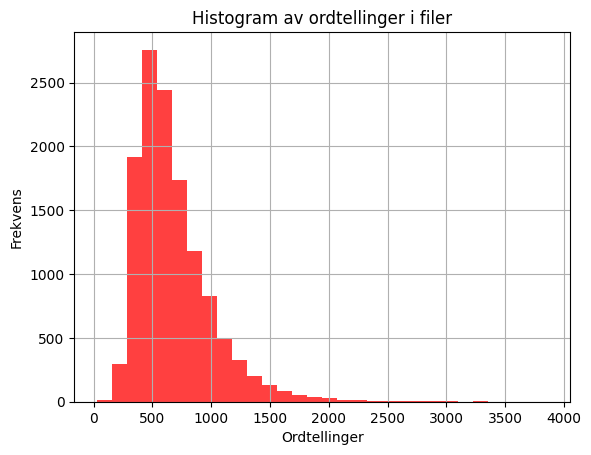

In [28]:
import os
import statistics
import matplotlib.pyplot as plt

# Funksjon for å telle ord i en fil
def count_words_in_file(file_path):
    try:
        with open(file_path, 'r') as file:
            contents = file.read()
            words = contents.split()
            return len(words)
    except Exception as e:
        print(f"Feil under lesing av {file_path}: {e}")
        return None

# Spesifiser banen til mappen din her
directory_path = 'transportklagenmnda_txt/'

# Liste for lagring av ordtelling
word_counts = []

# Går gjennom hver fil i mappen
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):  # Sjekker filtypen for å sikre at det er en tekstfil
        full_file_path = os.path.join(directory_path, filename)
        word_count = count_words_in_file(full_file_path)
        if word_count is not None:
            word_counts.append(word_count)

# Sjekker at det finnes ordtellinger for å beregne statistikk
if word_counts:
    # Beregner og skriver ut beskrivende statistikk
    print(f"Antall: {len(word_counts)}")
    print(f"Gjennomsnitt: {round(statistics.mean(word_counts),1)}")
    print(f"Median: {statistics.median(word_counts)}")
    print(f"Minimum: {min(word_counts)}")
    print(f"Maksimum: {max(word_counts)}")
    print(f"Standardavvik: {round(statistics.stdev(word_counts),1)}")
    
    # Lager et histogram over ordtellingene
    plt.hist(word_counts, bins=30, alpha=0.75, color='red')
    plt.xlabel('Ordtellinger')
    plt.ylabel('Frekvens')
    plt.title('Histogram av ordtellinger i filer')
    plt.grid(True)
    plt.show()

else:
    print("Ingen ordtellinger å beregne statistikk for.")


Statistikken viser at vi har noen dokumenter opp mot 3605 ord. Det betyr at noen av vedtakene har en lengde, og at anførsler og begrunnelser har et omfang som det må tas hensyn til når vi skal bruke tekstene som kontekst mot språkmodeller. Som en forberedelse undersøker vi derfor de lengste vedtakene litt nærmere.

Antall: 134
Minimum: 1803
Maksimum: 3862


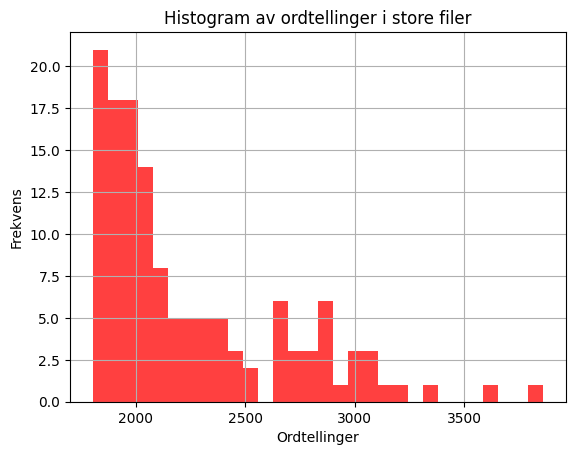

In [29]:
# Definerer først en grense for hva som er et "langt" dokument.
langt_dokument = 1800

# Filtrerer listen med ordtellinger slik at vi står igjen med lange dokumenter.
ordtellinger_lange = [count for count in word_counts if count >= langt_dokument]

# Lager statistikk for disse dokumentene
# Sjekker at det finnes ordtellinger for å beregne statistikk
if ordtellinger_lange:
    # Beregner og skriver ut beskrivende statistikk
    print(f"Antall: {len(ordtellinger_lange)}")
    print(f"Minimum: {min(ordtellinger_lange)}")
    print(f"Maksimum: {max(ordtellinger_lange)}")
    
    # Lager et histogram over ordtellingene
    plt.hist(ordtellinger_lange, bins=30, alpha=0.75, color='red')
    plt.xlabel('Ordtellinger')
    plt.ylabel('Frekvens')
    plt.title('Histogram av ordtellinger i store filer')
    plt.grid(True)
    plt.show()

else:
    print("Ingen ordtellinger å beregne statistikk for.")


Vi har 3 vedtak over 3000 ord og 16 vedtak over 2400 ord. Dette er en påminnelse om å sjekke lengden på hele eller deler av vedtaket når de skal brukes som kontekst.